# Retrieve, reformat, clean and store data of the Covid-19 pandemic

Data sources:
* John Hopkins University (**JHU**) - Center for System Science and Engineering (CSSE)
* Berliner Morgenpost (**BMP**)
* Landratsamt Traunstein (**LR TS**)

In [1]:
%reset -f
%matplotlib inline

In [2]:
from collections import namedtuple, OrderedDict
from datetime import datetime, timedelta
from pathlib import Path
import unittest

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 8)
pd.options.display.max_rows = 8
sns.set()

tc = unittest.TestCase('__init__')

## Retrieving JHU data
* Dashboard: https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6
* Data: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data

Data is available as git repo, thus transfer is compressed. It is assumed that the `COVID-19` repo is `git clone`'d at the same directory level as this `covid-19_analysis`.
```
cd ..
git clone  https://github.com/CSSEGISandData/COVID-19.git
```

In [3]:
covid_19_jhu_repo = Path('../COVID-19')

my_pwd = %pwd
%cd -q {covid_19_jhu_repo}
!git pull
%cd -q {my_pwd}

Already up to date.


In [4]:
filename_confirmed_global_JHU = (covid_19_jhu_repo /
  "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
assert filename_confirmed_global_JHU.exists()

confirmed_global_JHU = pd.read_csv(filename_confirmed_global_JHU)
print(confirmed_global_JHU.keys()[:5])
confirmed_global_JHU.set_index("Country/Region", inplace=True)
confirmed_global_JHU.head(3)

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20'], dtype='object')


,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,33.0000,65.0000,0,0,0,0,0,0,0,...,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102
Albania,NaN,41.1533,20.1683,0,0,0,0,0,0,0,...,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464
Algeria,NaN,28.0339,1.6596,0,0,0,0,0,0,0,...,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810


## Reformat JHU data

We are interested in the contries:
* Austria
* Germany
* France

We want the table have the data as coloumn (thus transpose it).

And the France data is scattered over the departments, thus we need to collect it.

In [5]:
COUNTRIES_SELECTED = ["Germany", "Austria", "France"]

date_columns = [c for c in confirmed_global_JHU.columns if c.endswith('/20')]
cases_JHU = (confirmed_global_JHU
    .loc[confirmed_global_JHU.index.isin(COUNTRIES_SELECTED), date_columns]
    .transpose()
    .reset_index()
    .rename(columns={'index': 'date'})
)
cases_JHU['date'] = pd.to_datetime(cases_JHU['date'])
cases_JHU.set_index('date', inplace=True)
print(cases_JHU.tail(1))

# there are multiple France, let's sum them to one new France2
cases_JHU['France2'] = cases_JHU['France'].sum(axis=1)
del cases_JHU['France']
_rd = OrderedDict([
    ('Germany', 'Germany_JHU'),
    ('Austria', 'Austria_JHU'),
    ('France2', 'France_JHU'),
])
cases_JHU.rename(columns=_rd, inplace=True)
cases_JHU = cases_JHU.reindex(_rd.values(), axis=1)
cases_JHU.tail(4)

Country/Region  Austria  France  France  France  France  France  France  \
date                                                                      
2020-06-13        17078    1161      60     171    2282      21     489   

Country/Region  France  France  France  France  Germany  France  
date                                                             
2020-06-13           6      42     202  189311   187267       1  


Country/Region,Germany_JHU,Austria_JHU,France_JHU
date,,,
2020-06-10,186522,17005,192068
2020-06-11,186691,17034,192493
2020-06-12,187226,17064,193220
2020-06-13,187267,17078,193746


## Plotting JHU data

In [6]:
#cases_JHU.plot(style='o-', logy=True)

## Retrieving BMP data

Total and recovered data are taken manually from the following URL:
* https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/


In [7]:
filename_BMP = Path("data_raw_BMP.csv")
cases_BMP = pd.read_csv(filename_BMP, index_col=[0], parse_dates=[0])
display(cases_BMP.tail(3))

try:
    tc.assertEqual(cases_BMP.index[-1], cases_JHU.index[-1])
except AssertionError as e:
    print("ERROR: manually add the missing data to %s" % filename_BMP)
    raise e

,confirmed,recovered_alive,death
date,,,
2020-06-11,186691,170961,8772
2020-06-12,187226,171535,8783
2020-06-13,187267,171970,8793


## Calculating infectious
    
$$I_t = I_{t-1} + \text{new cases}_t - \text{new recoveries}_t - \text{new death}_t$$

In [8]:
mask = cases_BMP['confirmed'] >= 20
c_diff = cases_BMP[['confirmed', 'recovered_alive', 'death']].diff().loc[mask]
display(c_diff.head(1))

N = len(c_diff)
infectious = np.empty(N, dtype='i4')
infectious[-1] = 1
for i in range(N):
    infectious[i] = infectious[i - 1] + c_diff['confirmed'].iloc[i] \
                    - c_diff['recovered_alive'].iloc[i] - c_diff['death'].iloc[i]

cases_BMP['infectious'] = pd.array([pd.NA] * len(cases_BMP), dtype=pd.Int32Dtype())
cases_BMP.loc[mask, 'infectious'] = infectious

cases_BMP['recovered'] = cases_BMP[['recovered_alive', 'death']].sum(axis=1).astype(pd.Int32Dtype())

for key in ['infectious', 'recovered']:
    tc.assertEqual(cases_BMP[key].dtype, pd.Int32Dtype())

,confirmed,recovered_alive,death
date,,,
2020-02-26,3.0,0.0,0.0


## Plotting BMP data

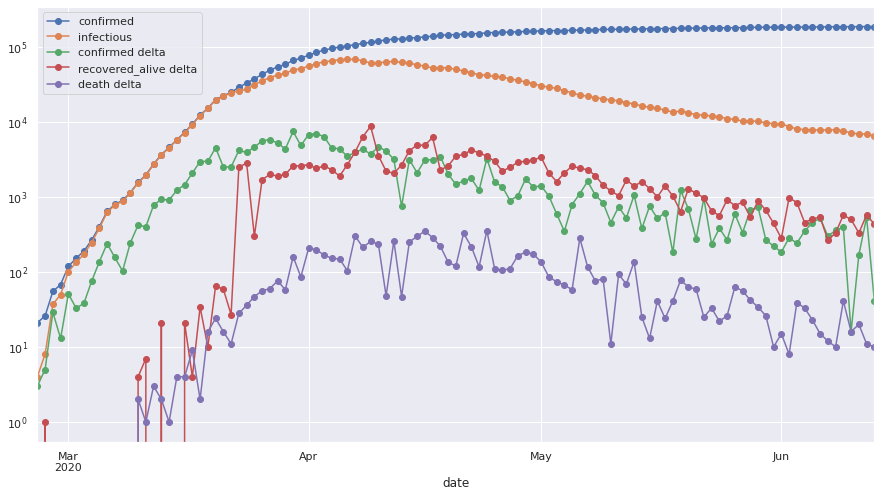

In [9]:
_kwargs = dict(style='o-', logy=True, legend=True)
ax = cases_BMP.loc[mask, ['confirmed', 'infectious']].plot(**_kwargs)
for key in c_diff.keys():
    c_diff[key].plot(ax=ax, label=key + ' delta', **_kwargs)

# Reading TS LR data

Extracted from: https://www.traunstein.com/aktuelles/meldungen/infos-rund-um-das-coronavirus

In [10]:
filename_TS_LR = Path("data_raw_TS_LR.csv")
cases_TS_LR = pd.read_csv(filename_TS_LR, index_col=[0], parse_dates=[0])
display(cases_TS_LR.head(3))

try:
    tc.assertEqual(cases_TS_LR.index[-1], cases_JHU.index[-1])
except AssertionError as e:
    print("ERROR: manually add the missing data to %s" % filename_BMP)
    raise e

#raise AssertionError("Update dummy data of 2020-06-13")

,confirmed,recovered_alive,death,active
date,,,,
2020-03-26,145,10.0,0.0,NaN
2020-03-27,158,10.0,0.0,NaN
2020-03-28,199,11.0,0.0,NaN


## Calculating infectious
    
$$I_t = I_{t-1} + \text{new cases}_t - \text{new recoveries}_t - \text{new death}_t$$

In [11]:
# first day get's NaN due to diff below
mask = cases_TS_LR.index >= datetime(2020, 3, 27)
c_diff = cases_TS_LR[['confirmed', 'recovered_alive', 'death']].diff().loc[mask]
display(c_diff.head(5))
#display(c_diff.tail(5))

N = len(c_diff)
infectious = np.empty(N, dtype='i4')
# TODO: unclear probably need 13 here
infectious[-1] = 1
for i in range(N):
    infectious[i] = infectious[i - 1] + c_diff['confirmed'].iloc[i] \
                    - c_diff['recovered_alive'].iloc[i] - c_diff['death'].iloc[i]

cases_TS_LR['infectious'] = pd.array([pd.NA] * len(cases_TS_LR), dtype=pd.Int32Dtype())
cases_TS_LR.loc[mask, 'infectious'] = infectious

cases_TS_LR['recovered'] = cases_TS_LR[['recovered_alive', 'death']].sum(axis=1).astype(pd.Int32Dtype())

for key in ['infectious', 'recovered']:
    tc.assertEqual(cases_TS_LR[key].dtype, pd.Int32Dtype())

cases_TS_LR.tail(5)

,confirmed,recovered_alive,death
date,,,
2020-03-27,13.0,0.0,0.0
2020-03-28,41.0,1.0,0.0
2020-03-29,23.0,1.0,0.0
2020-03-30,29.0,0.0,0.0
2020-03-31,20.0,4.0,0.0


,confirmed,recovered_alive,death,active,infectious,recovered
date,,,,,,
2020-06-09,1324,1105.0,87.0,132.0,-2,1192
2020-06-10,1325,1117.0,87.0,121.0,-13,1204
2020-06-11,1326,1119.0,87.0,120.0,-14,1206
2020-06-12,1326,1119.0,87.0,120.0,-14,1206
2020-06-13,1326,1119.0,87.0,120.0,-14,1206


## Plotting LR TS data

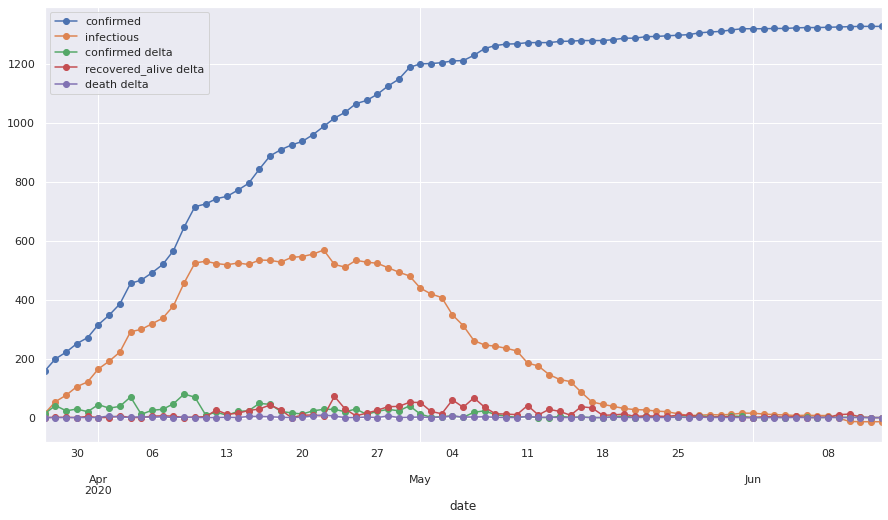

In [12]:
_kwargs = dict(style='o-', logy=False, legend=True)
ax = cases_TS_LR.loc[mask, ['confirmed', 'infectious']].plot(**_kwargs)
for key in c_diff.keys():
    c_diff[key].plot(ax=ax, label=key + ' delta', **_kwargs)

## Join JHU and BMP data, plot and write to file

In [13]:
df = cases_JHU.join(
    cases_BMP[['infectious', 'recovered']].rename(
        columns={'infectious': 'Germany_infectious_BMP',
                 'recovered': 'Germany_recovered_BMP'}
    ).join(
    cases_TS_LR[['infectious', 'recovered']].rename(
        columns={'infectious': 'TS_infectious_LR',
                 'recovered': 'TS_recovered_LR'})
    )
)
df.tail(3)

,Germany_JHU,Austria_JHU,France_JHU,Germany_infectious_BMP,Germany_recovered_BMP,TS_infectious_LR,TS_recovered_LR
date,,,,,,,
2020-06-11,186691,17034,192493,6956,179733,-14,1206
2020-06-12,187226,17064,193220,6906,180318,-14,1206
2020-06-13,187267,17078,193746,6502,180763,-14,1206


In [14]:
df.to_csv('cases.csv', line_terminator="\n")